<a href="https://colab.research.google.com/github/kndukuba17-hub/Bank-Customer-Churn-Prediction/blob/main/customer_predictive_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set visual style for professional charts
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries initialized. Ready to proceed.")

Libraries initialized. Ready to proceed.


In [2]:
def create_dataset(n=2000):
    np.random.seed(42) # Ensures reproducibility

    data = {
        'CustomerID': range(10001, 10001 + n),
        'CreditScore': np.random.randint(400, 850, n),
        'Geography': np.random.choice(['France', 'Germany', 'Spain'], n),
        'Gender': np.random.choice(['Male', 'Female'], n),
        'Age': np.random.normal(40, 10, n).astype(int),
        'Tenure': np.random.randint(0, 10, n),
        'Balance': np.random.uniform(0, 150000, n).round(2),
        'NumOfProducts': np.random.choice([1, 2, 3], n, p=[0.6, 0.3, 0.1]),
        'HasCrCard': np.random.choice([0, 1], n),
        'IsActiveMember': np.random.choice([0, 1], n),
        'EstimatedSalary': np.random.uniform(30000, 180000, n).round(2)
    }

    df = pd.DataFrame(data)

    # --- Engineering the Target Variable (Churn) ---
    # We want the model to actually find patterns, so we inject some logic:
    # Logic: High Churn probability if CreditScore < 500 OR Age > 55
    risk_score = (
        (df['CreditScore'] < 500).astype(int) * 3 +
        (df['Age'] > 55).astype(int) * 4 +
        (df['Balance'] > 100000).astype(int) * 1 -
        (df['IsActiveMember'] * 2)
    )

    # Add random noise to make it realistic (not a perfect correlation)
    risk_score += np.random.normal(0, 1.5, n)

    # Convert risk score to binary Churn label
    df['Exited'] = (risk_score > 1.5).astype(int)

    return df

# Initialize dataframe
df = create_dataset()

# Sanity check
print(f"Dataset successfully created with {df.shape[0]} rows and {df.shape[1]} columns.")
display(df.head())

Dataset successfully created with 2000 rows and 12 columns.


,CustomerID,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,10001,502,Spain,Female,28,1,132955.30,1,1,1,170411.03,0
1,10002,835,France,Male,46,3,125680.99,3,0,1,165411.07,0
2,10003,748,France,Male,46,0,132417.25,1,1,0,111491.70,0
3,10004,670,France,Male,31,4,138307.32,2,0,1,116596.74,0
4,10005,506,Germany,Male,48,5,15679.18,3,1,0,135752.58,0


/tmp/ipython-input-4275156200.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=df, palette='viridis', ax=axes[0])


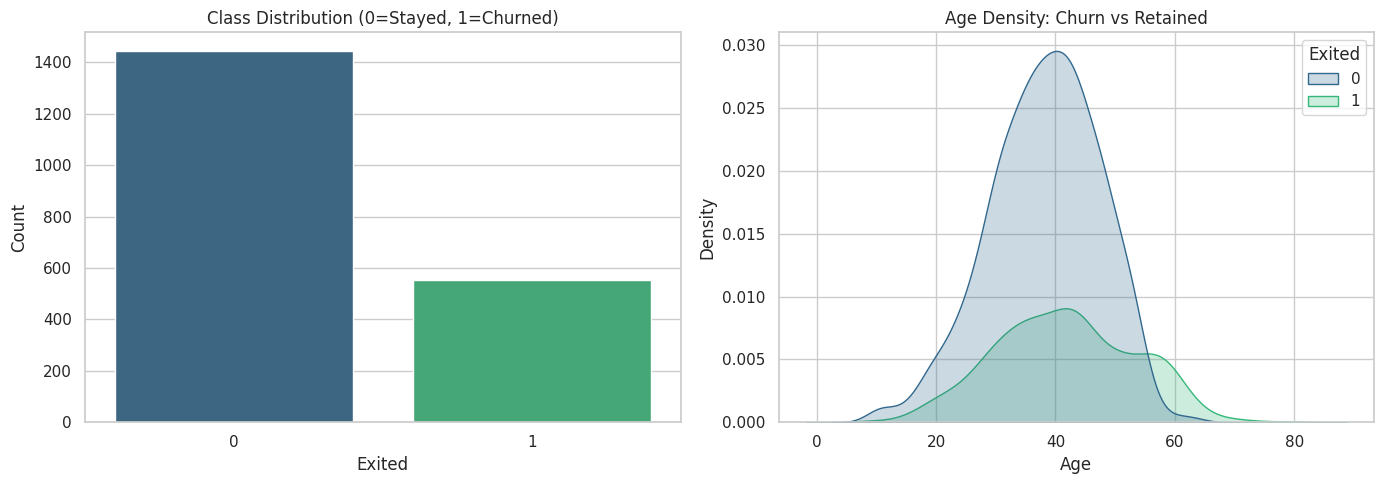

Overall Churn Rate: 27.8%


In [3]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class Balance
sns.countplot(x='Exited', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Class Distribution (0=Stayed, 1=Churned)')
axes[0].set_ylabel('Count')

# Plot 2: Age Distribution by Churn Status
sns.kdeplot(data=df, x='Age', hue='Exited', fill=True, palette='viridis', ax=axes[1])
axes[1].set_title('Age Density: Churn vs Retained')

plt.tight_layout()
plt.show()

# Insight Calculation
churn_rate = df['Exited'].mean()
print(f"Overall Churn Rate: {churn_rate:.1%}")

In [4]:
# 1. Drop irrelevant columns
X = df.drop(['CustomerID', 'Exited'], axis=1)
y = df['Exited']

# 2. Encode Categorical Data
# 'drop_first=True' prevents multicollinearity (dummy variable trap)
X = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)

# 3. Scale Features (Optional for Random Forest, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Training Features Shape: (1600, 11)
Testing Features Shape: (400, 11)


In [5]:
# Initialize the model with 100 decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
print("Training model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")

Training model...
Model training complete.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       289
           1       0.79      0.68      0.73       111

    accuracy                           0.86       400
   macro avg       0.84      0.81      0.82       400
weighted avg       0.86      0.86      0.86       400



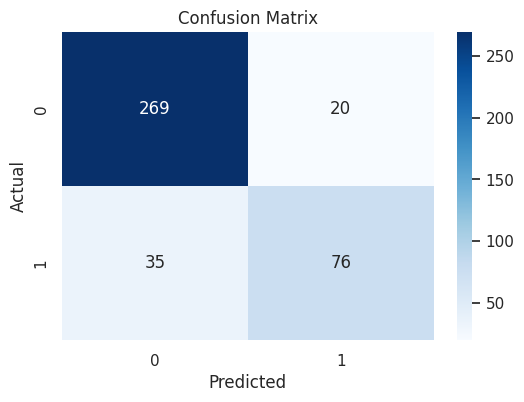

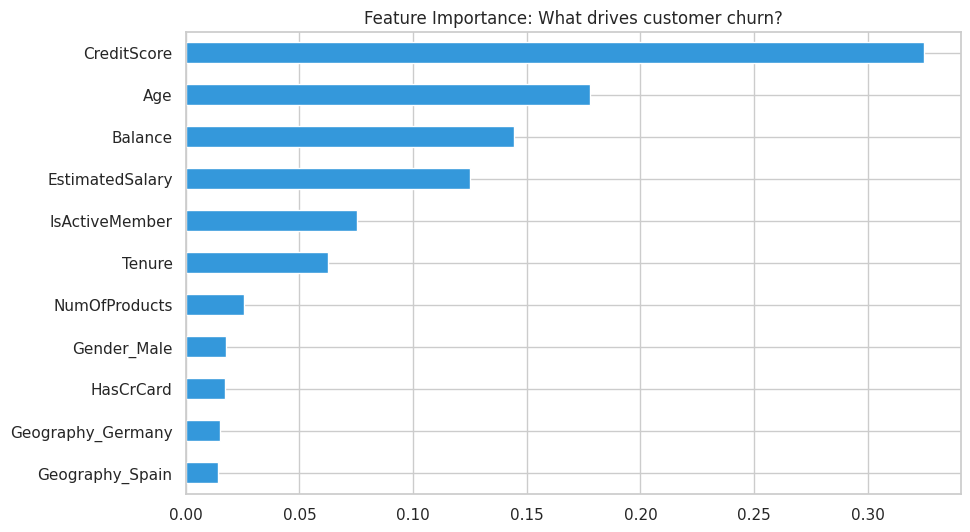

In [6]:
# Generate predictions
y_pred = rf_model.predict(X_test)

# 1. Performance Metrics
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. Feature Importance (The "Why")
# Map importance scores back to column names
feature_names = pd.get_dummies(df.drop(['CustomerID', 'Exited'], axis=1), drop_first=True).columns
importances = pd.Series(rf_model.feature_importances_, index=feature_names)

plt.figure(figsize=(10, 6))
importances.sort_values().plot(kind='barh', color='#3498db')
plt.title('Feature Importance: What drives customer churn?')
plt.show()